In [ ]:
import kagglehub
nikolasgegenava_popular_street_foods_path = kagglehub.dataset_download('nikolasgegenava/popular-street-foods')

print('Data source import complete.')


Data source import complete.


In [ ]:
"""
🍔 Popular Street Food Classification - Image Classification Using ResNet
--------------------------------------------------------------------------

This notebook demonstrates how to build a deep learning model to classify
images of popular street food items (e.g., Tacos, Pizza, Burger) using a ResNet-based classifier.
The dataset contains images of various street foods categorized into 20 classes.

Our goal is to accurately map these food items to their corresponding class labels using a pre-trained ResNet model,
fine-tuned for this specific classification task.

Key Steps:
- Loading and transforming image data from labeled folders
- Visualizing sample images
- Fine-tuning a ResNet model for classification
- Evaluating model performance with accuracy and F1-score
- Plotting training/validation metrics

Dataset Format:
- Structure: Root/Class_Name/Image.png
- Total Images: 3,896 across 20 food classes (Tacos, Pizza, Burger, etc.)

Libraries Used:
- PyTorch for model definition and training
- Torchvision for pre-trained ResNet, data transformations and loading
- Matplotlib & Seaborn for visualizations
- Scikit-learn for evaluation metrics
"""

# 📦 Import Required Libraries

# Standard imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# Sklearn for metrics
from sklearn.metrics import accuracy_score, f1_score

# ⚠️ Suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore")

# Set theme for plots
sns.set_theme(style="whitegrid")

## Dataset Overview


Classes: 20
Total Images: 3711


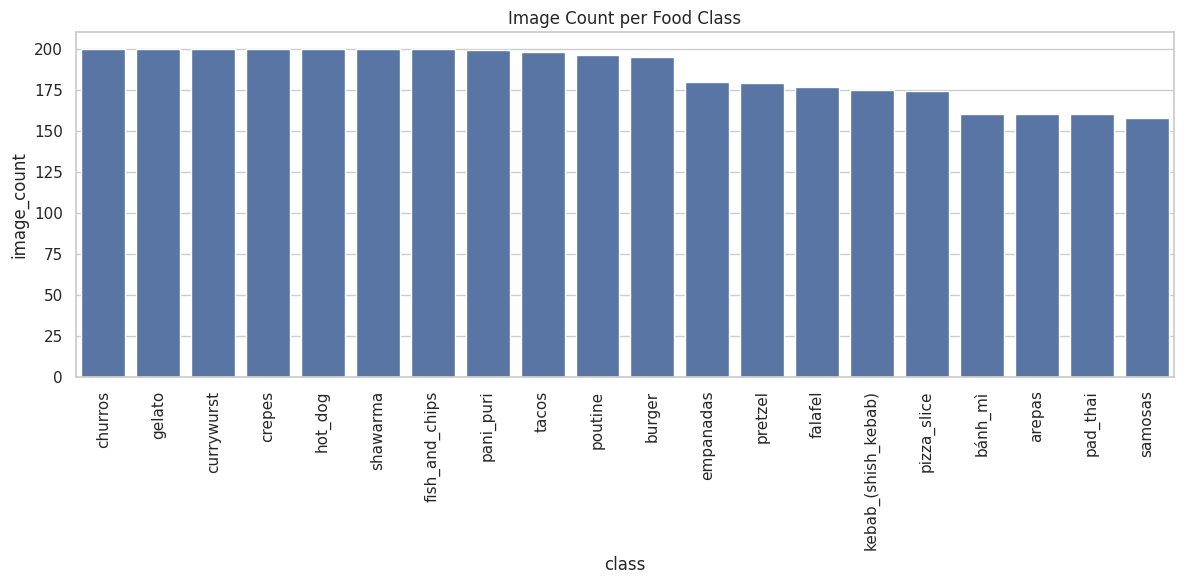

In [ ]:
# Load dataset statistics
stats_df = pd.read_csv("/kaggle/input/popular-street-foods/popular_street_foods/dataset_stats.csv")
print("Classes:", stats_df['class'].nunique())
print("Total Images:", stats_df['image_count'].sum())

# Display class-wise stats
plt.figure(figsize=(12, 6))
sns.barplot(x='class', y='image_count', data=stats_df.sort_values('image_count', ascending=False))
plt.xticks(rotation=90)
plt.title("Image Count per Food Class")
plt.tight_layout()
plt.show()

## Custom Dataset and Dataloaders

In [ ]:
# Define image transformations (Resize, Normalize)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset from folder
dataset = datasets.ImageFolder(root='/kaggle/input/popular-street-foods/popular_street_foods/dataset', transform=transform)

# Split into train/val
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Total Samples:", len(dataset))
print("Training Samples:", len(train_dataset))
print("Validation Samples:", len(val_dataset))

Total Samples: 3674
Training Samples: 3306
Validation Samples: 368


Batch image tensor shape: torch.Size([32, 3, 128, 128])
Batch label shape: torch.Size([32])


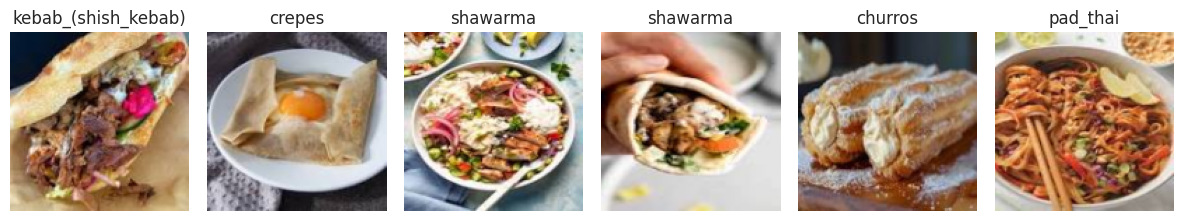

In [ ]:
# Preview one batch
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)  # [32, 3, 128, 128]
print("Batch label shape:", labels.shape)         # [32]

# Map class indices to class names
class_names = dataset.classes  # Automatically picked by ImageFolder from folder names

# Visualize few samples
def show_batch(img_batch, label_batch):
    plt.figure(figsize=(12, 4))
    for i in range(6):
        img = img_batch[i].permute(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]
        img = img * 0.5 + 0.5  # Unnormalize: reverse normalization
        plt.subplot(1, 6, i + 1)
        plt.imshow(img.numpy())
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_batch(images, labels)

# Model Training and Evaluation

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes (20)
model.fc = nn.Linear(model.fc.in_features, 20)

# Move model to device (GPU/CPU)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    # Print training statistics for each epoch
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {running_loss / len(train_loader):.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics for validation set
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    print("-" * 50)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


Epoch 1/10
Train Loss: 1.7771
Validation Loss: 1.0908
Validation Accuracy: 0.6875
Validation F1 Score: 0.6797
--------------------------------------------------
Epoch 2/10
Train Loss: 0.5168
Validation Loss: 0.9344
Validation Accuracy: 0.7228
Validation F1 Score: 0.7243
--------------------------------------------------
Epoch 3/10
Train Loss: 0.1494
Validation Loss: 0.8576
Validation Accuracy: 0.7446
Validation F1 Score: 0.7469
--------------------------------------------------
Epoch 4/10
Train Loss: 0.0569
Validation Loss: 0.8363
Validation Accuracy: 0.7446
Validation F1 Score: 0.7490
--------------------------------------------------
Epoch 5/10
Train Loss: 0.0283
Validation Loss: 0.8342
Validation Accuracy: 0.7554
Validation F1 Score: 0.7594
--------------------------------------------------
Epoch 6/10
Train Loss: 0.0204
Validation Loss: 0.8195
Validation Accuracy: 0.7500
Validation F1 Score: 0.7515
--------------------------------------------------
Epoch 7/10
Train Loss: 0.0145
Vali